In [1]:
import clearbox as cb
from clearbox import datasets
import clearbox.notebooks as nb

from clearbox.em import EM

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import colors

import math

# Expectation-maximization (EM)

An example of how EM works. Before we start, we'll define a few utility functions for our plots. You can ignore these for now.

This is a natural follow-up to the k-means notebook, so you may want to try that one first.

In [52]:
def rgb(c):
    return np.asarray(colors.to_rgb(c))
    
def plot_responsibilities(model, data, contrast=1.0, covs=False, oldmodel=None, changes=None):
    
    n, d = data.shape
    
    plt.figure(figsize=(6, 4.5))
    
    # Iterate over the three components
    compcolors = np.concatenate([
            rgb(nb.BLUE)[None, :],
            rgb(nb.RED)[None, :],
            rgb(nb.GREEN)[None, :]], axis=0)
    
    resp = model.responsibilities
    if contrast != 1.0:
        resp = resp ** contrast
        resp = resp / resp.sum(axis=1, keepdims=True)
    
    cols = np.einsum('kc, nk -> nc', compcolors, resp)

    
    a = 1.0 if changes is None else np.clip((changes / changes.max(axis=0, keepdims=True)), 0.3, 1)
    plt.scatter(data[:, 0], data[:, 1], s=32, color=cols, linewidth=0, alpha=a, marker='o')

    # Plot the means
    plot_components(model, plt.gca(), covs=covs)
    
    if oldmodel is not None:
        plot_old_components(oldmodel, plt.gca(), covs=covs)
    
    nb.cleaner()
    
def plot_start(model, data, covs=True, n_std=1):
    
    plt.figure(figsize=(6, 4.5))

    # The raw data (without species information)
    plt.scatter(x[:, 0], x[:, 1], s=s, alpha=0.6, color='k', marker='o', linewidth=0)
    
    plot_components(model, plt.gca(), covs=covs, n_std=n_std)

    nb.cleaner()
    
def plot_old_components(comps, ax, covs=False, n_std=1):
    
    means, covariances, weights = comps
    
    for i, col, m,in zip(range(3), [nb.BLUE, nb.RED, nb.GREEN], ['o', 'D', 'X']):
                
        ax.scatter(means[i, 0], means[i, 1], s=128, alpha=0.3, color=col, facecolor='none', linewidth=1, marker=m) 
        
        if covs:
            
            mean = means[i]
            cov = covariances[i]
            
            a = np.linalg.cholesky(cov)

#             ellipse1 = Ellipse((0, 0),
#                 width=2 * n_std,
#                 height= 2 * n_std,
#                 facecolor=col,
#                 angle= 0,
#                 alpha=weights[i] * 0.5,
#                 zorder=-10)
            
            ellipse2 = Ellipse((0, 0),
                width=2 * n_std,
                height= 2 * n_std,
                facecolor='None',
                edgecolor=col,
                linewidth=0.7,
                angle= 0,
                alpha=0.3,
                zorder=-10)            
            
#             # Transformation in homogeneous coordinates
            tm = np.block([ [a @ (np.eye(2) ), mean[:, None]], [0, 0, 1] ])
            transf = mpl.transforms.Affine2D()
            transf.set_matrix(tm)

#             ellipse1.set_transform(transf + ax.transData)            
            ellipse2.set_transform(transf + ax.transData)
            
#             ax.add_patch(ellipse1)
            ax.add_patch(ellipse2)    
    
def plot_components(model, ax, covs=False, n_std=1, uniform_color=None):
    
    for i, col, m in zip(range(3), [nb.BLUE, nb.RED, nb.GREEN] if uniform_color is None else [uniform_color] * model.k, ['o', 'D', 'X']):
                
        ax.scatter(model.means[i, 0], model.means[i, 1], s=128, alpha=1, color=col, linewidth=0, marker=m) 
        
        if covs:
            
            mean = model.means[i]
            cov = model.covariances[i]
            
            a = np.linalg.cholesky(cov)

            ellipse1 = Ellipse((0, 0),
                width=2 * n_std,
                height= 2 * n_std,
                facecolor=col,
                angle= 0,
                alpha=model.weights[i] * 0.5,
                zorder=-10)
            
            ellipse2 = Ellipse((0, 0),
                width=2 * n_std,
                height= 2 * n_std,
                facecolor='None',
                edgecolor=col,
                linewidth=0.7,
                angle= 0,
                alpha=1,
                zorder=-10)            
            
            # Transformation in homogeneous coordinates
            tm = np.block([ [a @ (np.eye(2) ), mean[:, None]], [0, 0, 1] ])
            transf = mpl.transforms.Affine2D()
            transf.set_matrix(tm)

            ellipse1.set_transform(transf + ax.transData)            
            ellipse2.set_transform(transf + ax.transData)
            
            ax.add_patch(ellipse1)
            ax.add_patch(ellipse2)
            
#             print(mean, cov)

#             N = 1000
#             mvn = np.random.multivariate_normal(mean=mean, cov=cov, size=N)
#             ax.scatter(mvn[:, 0], mvn[:, 1], s=64, alpha=0.2, color=col, linewidth=0, marker='.')
            
#             t = np.linspace(0, 2*math.pi, num=500)
            
#             circ = np.concatenate([np.cos(t)[:, None], np.sin(t)[:, None]], axis=1)
#             circ = circ * n_std
#             circ = circ @ a.T 
#             circ = circ + mean[None, :]
            
#             ax.plot(circ[:, 0], circ[:, 1])    

#             mvn = np.random.multivariate_normal(mean=[0, 0], cov=np.eye(2), size=N)
#             mvn = mvn @ a.T
#             mvn = mvn + mean[None, :]
#             print(mvn[:10])
            
#             ax.scatter(mvn[:, 0], mvn[:, 1], s=64, alpha=1, color=col, linewidth=0, marker='D')




In [3]:
colors.to_rgb(nb.BLUE)

(0.011764705882352941, 0.396078431372549, 0.7529411764705882)

We will demonstrate this on a subset of the Palmer penguin data. First we load it and we plot the data colored by species.

Text(0, 0.5, 'bill depth (mm)')

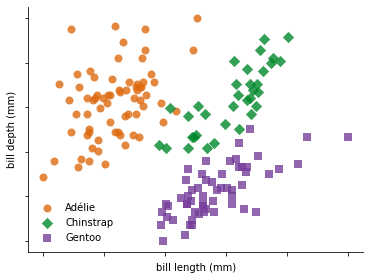

In [4]:
(x, y), _ = datasets.penguins_species()


plt.figure(figsize=(6, 4.5))


x1 = x[y == 0]
x2 = x[y == 1]
x3 = x[y == 2]


a = 0.8
s = 32
ps = cb.datasets.PENGUIN_SPECIES

plt.scatter(x1[:, 0], x1[:, 1], label=ps[0], s=s*2, alpha=a, color=nb.ORANGE, marker='o', linewidth=0)
plt.scatter(x2[:, 0], x2[:, 1], label=ps[1], s=s*2, alpha=a, color=nb.GREEN, marker='D', linewidth=0)
plt.scatter(x3[:, 0], x3[:, 1], label=ps[2], s=s*2, alpha=a, color=nb.PURPLE, marker='s', linewidth=0)

plt.xlabel('flipper length (dm)')
plt.ylabel('body mass (kg)')
plt.legend(frameon=False)

nb.cleaner()

plt.xlabel('bill length (mm)')
plt.ylabel('bill depth (mm)')

# plt.savefig('bill_data.pdf')


Note that the species information won't be passed to the clustering algorithm. We'll only give it the raw data. 

Next, we initialize the k-means model. We provide it with the number of clusters we'd like for this data, and we initialize the means to random values.

In [5]:
# Create the model
model = EM(k=3)

model.reset_components(data=x) 

model.covariances = model.covariances * 0.03
# -- This last step is normally done automatically when you call model.fit(), but this way, we can see what the model looks like
#    before it has trained.

The model hasn't done any training yet. It has just picked three random points in our feature space, which we call the "means" of the three clusters. Let's plot the data as the model sees it, together with these three means.

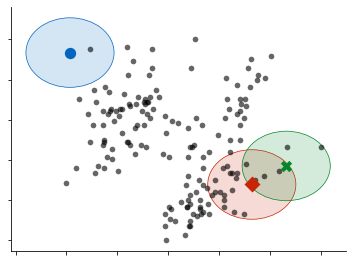

In [6]:
plot_start(model, data=x, covs=True, n_std=1)
plt.savefig('gmm-start.pdf')

The means are placed completely randomly in the data's bounding box. To center them on the natural clusters of the data, the k-means algorithm repeats two steps: **cluster assignment** and **recomputing the means**.

Let's start with cluster assignment. We simply iterate over all points in the data and assign them to the cluster corresponding to the mean that they are closest to. That is, the points that are closest to the red diamond are colored red, the points that are closes to the blue disc are colored blue and the points that are closest to the green cross are colored green.

This is implemented in the function `model.assign_clusters()`. The function returns the number of instances whose cluster assignment has changed (in this case all of them).

In [7]:
changes = model.assign_responsibilities(data=x)

changes[:10]

array([1.26125249, 0.76970817, 0.80130753, 1.46823982, 1.10718413,
       1.22827907, 0.99979964, 1.28567244, 0.41934731, 0.72776004])

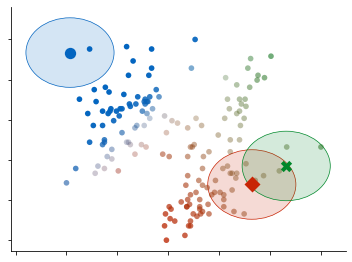

In [8]:
plot_responsibilities(model, data=x, contrast=1.0, covs=True, changes=changes)
plt.savefig('assign-responsibilities-0.pdf')

The next step is to remove the means and recompute new means as the average of all the points in each cluster. The function return the average change in the means.

In [9]:
old = model.means.copy(), model.covariances.copy(), model.weights.copy()
model.fit_components(data=x)

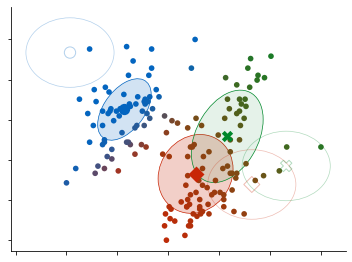

In [10]:
plot_responsibilities(model, x, covs=True, oldmodel=old)

In [11]:
model = EM(k=3)
model.reset_components(data=x) 
# model.covariances = model.covariances * 0.001

model.fit(x)

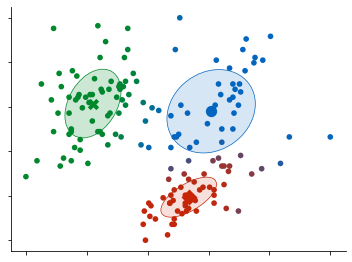

In [12]:
plot_responsibilities(model, x, covs=True)

# MNIST data 

For a higher-dimensional example, let's try this on the MNIST data. Note that this data has more that 700 dimensions (one per pixel) and we are estimating full covariance matrices of 700^2 dimensions. 

In [13]:
(x, y), _ = cb.datasets.mnist()

In [14]:
model = EM(k=10)

In [15]:
# model.fit(x, verbose=1)

# Lecture stuff

In [16]:
means = np.asarray([[2, 4], [4, 2], [1, 1]])
covs = np.asarray([ [[2, 0.2], [0.2, 0.05]], [[1, 0.1], [0.1, 1]], [[0.5, -0.1], [-0.1, 0.5]] ])
weights = np.asarray([0.3, 0.6, 0.1])

model = EM(k=3)

model.means = means
model.covariances = covs
model.weights = weights

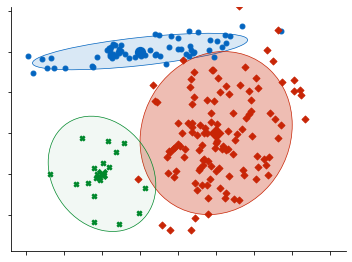

In [17]:
plt.figure(figsize=(6, 4.5))
plot_components(model, plt.gca(), covs=True, n_std=2)

nb.cleaner()

plt.gca().set_xlim(-1.4, 7.4)
plt.gca().set_ylim(-0.9, 5.1)
plt.savefig('gmm-2d.pdf')

n = 200
xs, cs = [], []

for i in range(n):
    c = np.random.choice(3, 1, p=model.weights)[0]
    cs.append(c)
    xs.append(np.random.multivariate_normal(mean=model.means[c], cov=model.covariances[c]) [None, :] )
    
xs = np.concatenate(xs, axis=0)  
cs = np.asarray(cs)

for i, col, m in zip(range(3), [nb.BLUE, nb.RED, nb.GREEN], ['o', 'D', 'X']):
    sub = xs[cs==i]
    plt.scatter(sub[:, 0], sub[:, 1], s=24, color=col, marker=m)

plt.gca().set_xlim(-1.4, 7.4)
plt.gca().set_ylim(-0.9, 5.1)
plt.savefig('gmm-2d-with-sample.pdf')



In [18]:
# np.random.seed(8)

# (x, y), _ = datasets.penguins_species()

# model = EM(k=3)

# model.reset_components(data=x) 
# model.covariances = model.covariances * 0.03

# plot_start(model, data=x, covs=True, n_std=1)
# plt.savefig('gmm-start.pdf')

# it = 0
# ch = float('inf')

# plotat = list(range(21)) + [21, 40, 41, 50, 51, 75, 76, 100, 101, 124, 125, 150, 151, 200, 201]

# while it < 1e5 and ch > 1e-10:
#     changes = model.assign_responsibilities(data=x)
    
#     if it in plotat:
#         plot_responsibilities(model, data=x, contrast=1.0, covs=True, changes=changes if it != 0 else None)
#         plt.savefig(f'assign-responsibilities-{it}.pdf')
    
#     old = model.means.copy(), model.covariances.copy(), model.weights.copy()
#     model.fit_components(data=x)
    
    
#     if it in plotat:
#         plot_responsibilities(model, x, covs=True, oldmodel=old)
#         plt.savefig(f'recompute-components-{it}.pdf')
    
#     ch = changes.mean()
#     it += 1
    
# it

In [19]:
it

NameError: name 'it' is not defined

# Classification

In [20]:
(x, y), _ = datasets.penguins_sex()

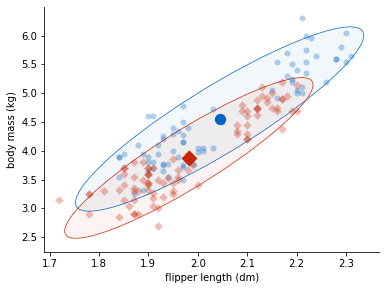

In [48]:
xm = x[y==1] 
xf = x[y==0]

plt.figure(figsize=(6, 4.5))

plt.scatter(xm[:, 0], xm[:, 1], color=nb.BLUE, marker='o', alpha=0.3, linewidth=0)
plt.scatter(xf[:, 0], xf[:, 1], color=nb.RED, marker='D', alpha=0.3, linewidth=0)

nb.clean()

plt.xlabel('flipper length (dm)')
plt.ylabel('body mass (kg)')

ax = plt.gca()
n_std = 2

for data, col, m in zip([xm, xf], [nb.BLUE, nb.RED], ['o', 'D']):
    
    cov = np.cov(data.T)
    mn = data.mean(axis=0)
    
    ax.scatter(mn[0], mn[1], s=128, alpha=1, color=col, linewidth=0, marker=m) 

    a = np.linalg.cholesky(cov)

    ellipse1 = Ellipse((0, 0),
        width=2 * n_std,
        height= 2 * n_std,
        facecolor=col,
        angle= 0,
        alpha=model.weights[i] * 0.5,
        zorder=-10)

    ellipse2 = Ellipse((0, 0),
        width=2 * n_std,
        height= 2 * n_std,
        facecolor='None',
        edgecolor=col,
        linewidth=0.7,
        angle= 0,
        alpha=1,
        zorder=-10)            

    # Transformation in homogeneous coordinates
    tm = np.block([ [a @ (np.eye(2) ), mn[:, None]], [0, 0, 1] ])
    transf = mpl.transforms.Affine2D()
    transf.set_matrix(tm)

    ellipse1.set_transform(transf + ax.transData)            
    ellipse2.set_transform(transf + ax.transData)

    ax.add_patch(ellipse1)
    ax.add_patch(ellipse2)
    
plt.savefig('one-gaussian.pdf')




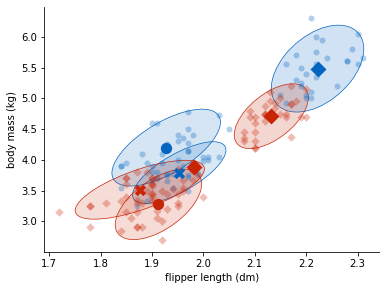

In [54]:
xm = x[y==1] 
xf = x[y==0]

plt.figure(figsize=(6, 4.5))

plt.scatter(xm[:, 0], xm[:, 1], color=nb.BLUE, marker='o', alpha=0.3, linewidth=0)
plt.scatter(xf[:, 0], xf[:, 1], color=nb.RED, marker='D', alpha=0.3, linewidth=0)

nb.clean()

plt.xlabel('flipper length (dm)')
plt.ylabel('body mass (kg)')

ax = plt.gca()
n_std = 2

for data, col, m in zip([xm, xf], [nb.BLUE, nb.RED], ['o', 'D']):
    
    model = EM(k=3)
    model.fit(data)
    
    ax.scatter(mn[0], mn[1], s=128, alpha=1, color=col, linewidth=0, marker=m) 

    plot_components(model, ax, covs=True, n_std=2, uniform_color=col)
    
plt.savefig('mixture-gaussian.pdf')